# ハードマージンでの実装

In [14]:
import numpy as np
from operator import itemgetter


class SVC:
    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        ayx = np.zeros(X.shape[1])
        yx = y.reshape(-1, 1)*X
        indices = np.arange(X.shape[0])
        while True:
            ydf = y*(1-np.dot(yx, ayx.T))
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[(y < 0) | (a > 0)],
                        key=itemgetter(1))[0])
            j = int(max(iydf[(y > 0) | (a > 0)],
                        key=itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i, :] - y[j]*a[j]*X[j, :]
            ai = ((1-y[i]*y[　j]
                   + y[i]*np.dot(X[i, :] - X[j, :],
                                 X[j, :]*ay2 - ayx2))
                  / ((X[i] - X[j])**2).sum())
            if ai < 0:
                ai = 0
            aj = (-ai * y[i] - ay2) * y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j] - ay2)*y[i]
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            ayx += y[i]*(ai - a[i])*X[i, :] + y[j]*(aj - a[j])*X[j, :]
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        ind = a != 0.
        self.w_ = ((a[ind] * y[ind]).reshape(-1, 1)
                   * X[ind, :]).sum(axis=0)
        self.w0_ = (y[ind]
                    - np.dot(X[ind, :], self.w_)).sum() / ind.sum()

    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))


# 実行結果

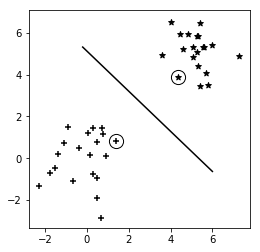

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import svm_hard

plt.axes().set_aspect("equal")
np.random.seed(15816054)
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([5, 5])
y = np.array([1] * 20 + [-1] * 20)

X = np.r_[X0, X1]
model = svm_hard.SVC()
model.fit(X, y)

plt.scatter(X0[:, 0], X0[:, 1], color="k", marker="+")
plt.scatter(X1[:, 0], X1[:, 1], color="k", marker="*")


def f(model, x):
    return (-model.w0_ - model.w_[0] * x) / model.w_[1]


x1 = -0.2
x2 = 6
plt.plot([x1, x2], [f(model, x1), f(model, x2)], color="k")
plt.scatter(X[model.a_ != 0, 0], X[model.a_ != 0, 1],
            s=200, color=(0, 0, 0, 0), edgecolor="k", marker="o")

plt.show()


# ソフトマージンでの実装

In [6]:
import numpy as np
from operator import itemgetter


class SVC:
    def __init__(self, C=1.):
        self.C = C

    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        ayx = np.zeros(X.shape[1])
        yx = y.reshape(-1, 1)*X
        indices = np.arange(X.shape[0])
        while True:
            ydf = y*(1-np.dot(yx, ayx.T))
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[((a > 0) & (y > 0)) |
                             ((a < self.C) & (y < 0))],
                        key=itemgetter(1))[0])
            j = int(max(iydf[((a > 0) & (y < 0)) |
                             ((a < self.C) & (y > 0))],
                        key=itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i, :] - y[j]*a[j]*X[j, :]
            ai = ((1-y[i]*y[j]
                   + y[i]*np.dot(X[i, :] - X[j, :],
                                 X[j, :]*ay2 - ayx2))
                  / ((X[i] - X[j])**2).sum())
            if ai < 0:
                ai = 0
            elif ai > self.C:
                ai = self.C
            aj = (-ai * y[i] - ay2) * y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j]-ay2)*y[i]
            elif aj > self.C:
                aj = self.C
                ai = (-aj*y[j]-ay2)*y[i]
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            ayx += y[i]*(ai - a[i])*X[i, :] + y[j]*(aj - a[j])*X[j, :]
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        ind = a != 0.
        self.w_ = ((a[ind] * y[ind]).reshape(-1, 1)
                   * X[ind, :]).sum(axis=0)
        self.w0_ = (y[ind]
                    - np.dot(X[ind, :], self.w_)).sum() / ind.sum()

    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))


# 実行結果

正しく分類できた数: 40


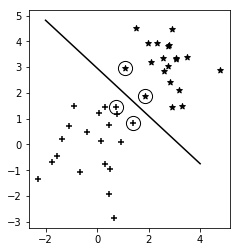

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import svm_soft

plt.axes().set_aspect("equal")
np.random.seed(15816054)
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([2.5, 3])
y = np.array([1] * 20 + [-1] * 20)

X = np.r_[X0, X1]

model = svm_soft.SVC()
model.fit(X, y)

plt.scatter(X0[:, 0], X0[:, 1], color="k", marker="+")
plt.scatter(X1[:, 0], X1[:, 1], color="k", marker="*")


def f(model, x):
    return (-model.w0_ - model.w_[0] * x) / model.w_[1]


x1 = -2
x2 = 4
plt.plot([x1, x2], [f(model, x1), f(model, x2)], color="k")
print("正しく分類できた数:", (model.predict(X) == y).sum())
plt.scatter(X[model.a_ != 0, 0], X[model.a_ != 0, 1],
            s=200, color=(0, 0, 0, 0), edgecolor="k", marker="o")


def f(model, xx):
    return model.w0_+np.dot(model.w_, xx)


plt.show()


# カーネル法を用いた実装

In [10]:
import numpy as np
from operator import itemgetter


class RBFKernel:
    def __init__(self, X, sigma):
        self.sigma2 = sigma**2
        self.X = X
        self.values_ = np.empty((X.shape[0], X.shape[0]))

    def value(self, i, j):
        return np.exp(-((self.X[i, :] - self.X[j, :])**2).sum()
                      / (2*self.sigma2))

    def eval(self, Z, s):
        return np.exp(-((self.X[s, np.newaxis, :]
                         - Z[np.newaxis, :, :])**2).sum(axis=2)
                      / (2*self.sigma2))


class SVC:
    def __init__(self, C=1., sigma=1., max_iter=10000):
        self.C = C
        self.sigma = sigma
        self.max_iter = max_iter

    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        kernel = RBFKernel(X, self.sigma)
        indices = np.arange(X.shape[0])
        for _ in range(self.max_iter):
            s = a != 0.
            ydf = y * (1 - y*np.dot(a[s]*y[s],
                                    kernel.eval(X, s)).T)
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[((a > 0) & (y > 0)) |
                             ((a < self.C) & (y < 0))],
                        key=itemgetter(1))[0])
            j = int(max(iydf[((a > 0) & (y < 0)) |
                             ((a < self.C) & (y > 0))],
                        key=itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            kii = kernel.value(i, i)
            kij = kernel.value(i, j)
            kjj = kernel.value(j, j)
            s = a != 0.
            s[i] = False
            s[j] = False
            kxi = kernel.eval(X[i, :].reshape(1, -1), s).ravel()
            kxj = kernel.eval(X[j, :].reshape(1, -1), s).ravel()
            ai = ((1 - y[i]*y[j]
                   + y[i]*((kij - kjj)*ay2
                           - (a[s]*y[s]*(kxi-kxj)).sum()))
                  / (kii + kjj - 2*kij))
            if ai < 0:
                ai = 0
            elif ai > self.C:
                ai = self.C
            aj = (-ai*y[i] - ay2)*y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j] - ay2)*y[i]
            elif aj > self.C:
                aj = self.C
                ai = (-aj*y[j] - ay2)*y[i]
            ay += y[i] * (ai-a[i]) + y[j] * (aj-a[j])
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        self.y_ = y
        self.kernel_ = kernel
        s = a != 0.
        self.w0_ = (y[s]
                    - np.dot(a[s]*y[s],
                             kernel.eval(X[s], s))).sum() / s.sum()
        with open("svm.log", "w") as fp:
            print(a, file=fp)

    def predict(self, X):
        s = self.a_ != 0.
        return np.sign(self.w0_
                       + np.dot(self.a_[s]*self.y_[s],
                                self.kernel_.eval(X, s)))


# 実行結果

正しく分類できた数: 198


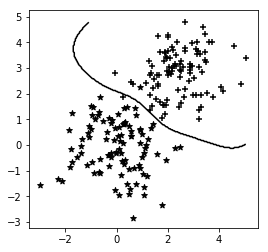

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import svm

plt.axes().set_aspect("equal")
np.random.seed(15816054)
X0 = np.random.randn(100, 2)
X1 = np.random.randn(100, 2) + np.array([2.5, 3])
y = np.array([1] * 100 + [-1] * 100)
X = np.r_[X0, X1]

model = svm.SVC()
model.fit(X, y)

xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

plt.scatter(X0[:, 0], X0[:, 1], color="k", marker="*")
plt.scatter(X1[:, 0], X1[:, 1], color="k", marker="+")
xmesh, ymesh = np.meshgrid(np.linspace(xmin, xmax, 200),
                           np.linspace(ymin, ymax, 200))
Z = model.predict(np.c_[xmesh.ravel(), ymesh.ravel()]).reshape(xmesh.shape)
plt.contour(xmesh, ymesh, Z, levels=[0], colors="k")

print("正しく分類できた数:", (model.predict(X) == y).sum())
plt.show()
